In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

In [2]:
# Read in Kickstarter data
kickstarter = pd.read_csv(r'C:\Users\Tom\Documents\Kickstarter\kickstarter.csv', index_col=0)

In [3]:
# Read in text data as csv:
kickstarter_vocab = pd.read_csv(r'C:\Users\Tom\Documents\Kickstarter\kickstarter_vocab.csv', index_col=0)

In [4]:
kickstarter_features = kickstarter[['name', 'blurb', 'goal_USD', 'category_name', 'category_slug', 'month', 'day', 'hour', 'blurb_length', 'days_to_deadline']]
kickstarter_response = kickstarter['binary_state']
kickstarter_features = kickstarter_features.drop(['name', 'blurb', 'hour', 'blurb_length'], axis=1)

# Log tranforming usd_raised and dropping goal_USD

kickstarter_features['log_goal'] = kickstarter.goal_USD.apply(lambda x: np.log1p(x))
kickstarter_features.drop('goal_USD', axis=1, inplace=True)

In [5]:
# Encoding category columns

kickstarter_features = pd.get_dummies(kickstarter_features, columns=['category_name', 'category_slug'])
kickstarter_features.head()

,days_to_deadline,log_goal,category_name_3D Printing,category_name_Academic,category_name_Accessories,category_name_Action,category_name_Animals,category_name_Animation,category_name_Anthologies,category_name_Apparel,...,category_slug_fashion,category_slug_film & video,category_slug_food,category_slug_games,category_slug_journalism,category_slug_music,category_slug_photography,category_slug_publishing,category_slug_technology,category_slug_theater
0,42,7.601402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,2.397895,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,6.803505,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,6.803505,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,10.034632,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Combining words with features already in place

combined = pd.merge(kickstarter_features, kickstarter_vocab, left_index=True, right_index=True).reset_index()

In [7]:
# Renaming to kickstarter_features to coincide with rest of code. Dropped index (all 0's)

kickstarter_features = combined.drop(['index'], axis=1)

In [8]:
# Binarizing labels into yes/no for successful/failed

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(kickstarter_response).ravel()

In [9]:
# Scaling features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(kickstarter_features)

In [10]:
# Minmax scaler for Naive Bayes
def minmaxscaling(X):
    ''' Performs minmaxscaling for Naive Bayes. Returns transformed matrix. '''
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X = scaler.fit_transform(kickstarter_features)
    return (X)

In [11]:
# Splitting data into training and testing. In function to call before naive bayes.

def train_test_split(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
# Function to score different machine learning models.

def score_model(clf, X_input_data, y_true):
    '''
    Scores a machine learning model, provides summary statistics, plots ROC curve.
   
    Inputs: classifier, X_input_data (X_train or X_test), y_true (y_train or y_test)
    ''' 
    
    # Scoring models. Test model. Change to allow prediction for X_train
    y_pred = clf.predict(X_input_data)

    # Fit an accuracy score
    from sklearn.metrics import accuracy_score
    print('\n Accuracy Score: \n \n', "{:.2%}".format(accuracy_score(y_true, y_pred, normalize=True)))

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    print('\n Confusion Matrix: \n \n', confusion_matrix(y_true, y_pred))

    # Print classification report
    from sklearn.metrics import classification_report
    print('\n Classification Report: \n \n', classification_report(y_true, y_pred))

    # Generate ROC plot
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt

    # Compute predicted probabilities: y_pred_prob. Try except for SGD: hinge loss model.
    try:
        y_pred_prob = clf.predict_proba(X_input_data)[:,1]
        
        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

        # Plot ROC curve
        f, ax = plt.subplots(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    
    except AttributeError:
        print('Probability estimates not available \n')
        

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
fitted = logreg.fit(X_train, y_train)
score_model(fitted, X_train, y_train)


C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 Accuracy Score: 
 
 72.90%

 Confusion Matrix: 
 
 [[144240  28231]
 [ 50028  66229]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.74      0.84      0.79    172471
           1       0.70      0.57      0.63    116257

    accuracy                           0.73    288728
   macro avg       0.72      0.70      0.71    288728
weighted avg       0.73      0.73      0.72    288728



<Figure size 800x800 with 1 Axes>


 Accuracy Score: 
 
 72.12%

 Confusion Matrix: 
 
 [[70378 14368]
 [25277 32187]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.74      0.83      0.78     84746
           1       0.69      0.56      0.62     57464

    accuracy                           0.72    142210
   macro avg       0.71      0.70      0.70    142210
weighted avg       0.72      0.72      0.72    142210



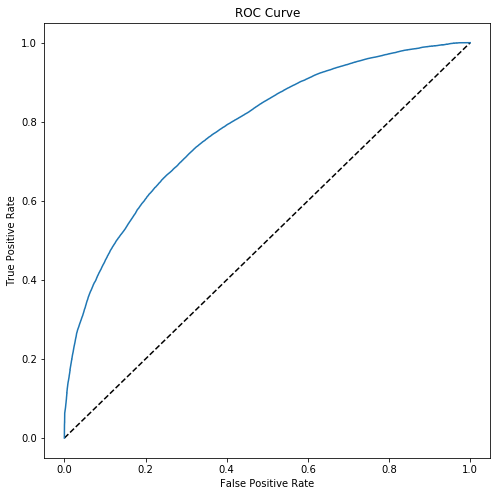

In [14]:
# Get accuracy score:

score_model(fitted, X_test, y_test)

In [17]:
# Getting logistic regression coefficients

coefs = logreg.coef_.transpose()
feature_list = list(kickstarter_features)
df = pd.DataFrame(coefs, feature_list)
df.columns = ['Coefs']
df['Abs_Coefs'] = df['Coefs'].apply(lambda x: abs(x))
df.sort_values('Abs_Coefs', ascending=False).head(50)


,Coefs,Abs_Coefs
log_goal,-0.502111,0.502111
category_name_Tabletop Games,0.306371,0.306371
category_name_Apps,-0.265483,0.265483
days_to_deadline,-0.259011,0.259011
category_name_Shorts,0.251948,0.251948
category_name_Theater,0.236433,0.236433
category_name_Web,-0.225359,0.225359
category_name_Photography,0.221852,0.221852
category_name_Food,0.209004,0.209004
category_name_Documentary,0.202583,0.202583


In [26]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
x = np.arange(10)[:, np.newaxis]
y = np.array([0,0,0,1,0,0,1,1,1,1])
model = LogisticRegression(C=1e30).fit(x, y)
print(logit_pvalue(model, x))

# compare with statsmodels
import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.11413093 0.08779978]
[0.11413093 0.08779979]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                          Logit   Df Residuals:                        8
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Jul 2019   Pseudo R-squ.:                  0.4856
Time:                        17:33:34   Log-Likelihood:                -3.5656
converged:                       True   LL-Null:                       -6.9315
                                        LLR p-value:                  0.009472
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9587      2.506     -1.580      0.114      -8.870       0.952
x1             0.8797      0.515      1.707      0.088      -0.130       1.890
==============================================================================
"""

In [ ]:
# Fitting logistic regression model with cross validation
# Use cross-validation with training data, test with testing data. Model leaking otherwise.
from sklearn.linear_model import LogisticRegressionCV
logregcv = LogisticRegressionCV(cv=10, random_state=42, max_iter=1000)
fitted = logregcv.fit(X_train, y_train)

# Train accuracy score
score_model(fitted, X_train, y_train)

In [ ]:
# Test accuracy score

score_model(fitted, X_test, y_test)

In [15]:
# Getting logistic regression coefficients for cross validated model (when it was just words. Keeping for top words)

coefs = logregcv.coef_.transpose()
feature_list = list(kickstarter_features)
df = pd.DataFrame(coefs, feature_list)
df.columns = ['Coefs']
df['Abs_Coefs'] = df['Coefs'].apply(lambda x: abs(x))
df.sort_values('Abs_Coefs', ascending=False).head(10)

,Coefs,Abs_Coefs
cancel,-3.158402,3.158402
miniatures,1.175928,1.175928
stretch,1.054835,1.054835
cthulhu,0.923606,0.923606
app,-0.884513,0.884513
suspend,-0.804500,0.804500
shooter,-0.793495,0.793495
application,-0.783378,0.783378
multiplayer,-0.767146,0.767146
thesis,0.767105,0.767105



 Accuracy Score: 
 
 70.10%

 Confusion Matrix: 
 
 [[136415  36056]
 [ 50273  65984]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76    172471
           1       0.65      0.57      0.60    116257

    accuracy                           0.70    288728
   macro avg       0.69      0.68      0.68    288728
weighted avg       0.70      0.70      0.70    288728



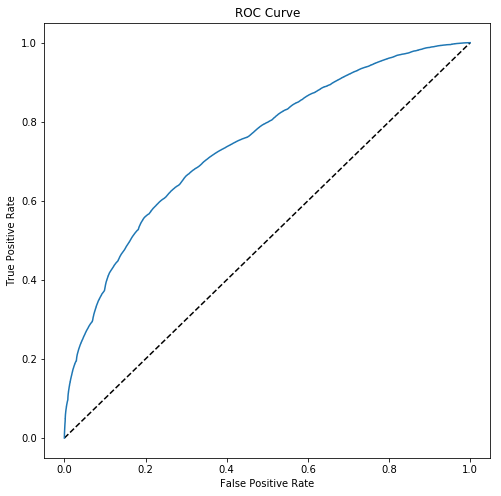

In [19]:
# For Naive Bayes, make sure to run with MinMaxScaler first

from sklearn.naive_bayes import MultinomialNB
X = minmaxscaling(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)
nb = MultinomialNB()
fitted = nb.fit(X_train, y_train.ravel())
score_model(fitted, X_train, y_train)


 Accuracy Score: 
 
 70.47%

 Confusion Matrix: 
 
 [[67182 17564]
 [24434 33030]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76     84746
           1       0.65      0.57      0.61     57464

    accuracy                           0.70    142210
   macro avg       0.69      0.68      0.69    142210
weighted avg       0.70      0.70      0.70    142210



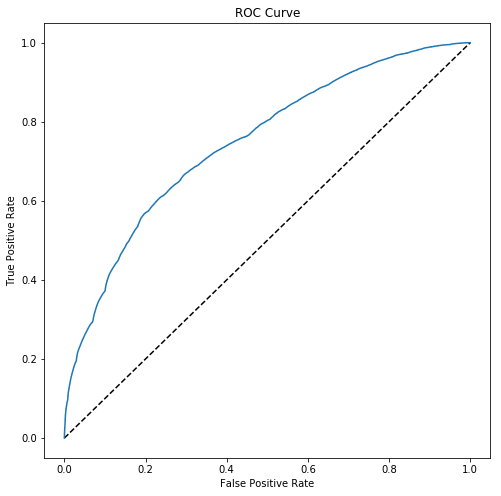

In [20]:
score_model(fitted, X_test, y_test)

C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



 Accuracy Score: 
 
 93.97%

 Confusion Matrix: 
 
 [[165243   7228]
 [ 10173 106084]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95    172471
           1       0.94      0.91      0.92    116257

    accuracy                           0.94    288728
   macro avg       0.94      0.94      0.94    288728
weighted avg       0.94      0.94      0.94    288728



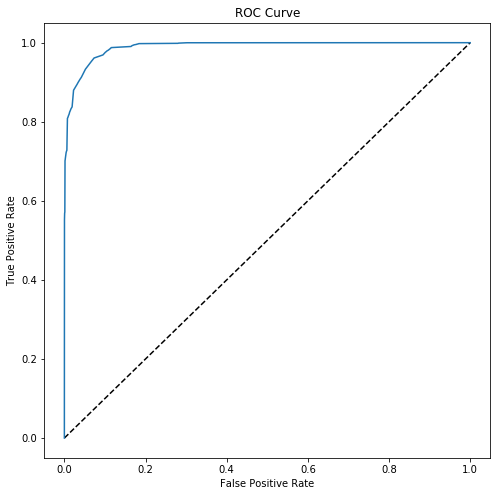

In [21]:
# Fitting random forest model, getting model coefficients

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
fitted = rf.fit(X_train, y_train)
score_model(fitted, X_train, y_train)



 Accuracy Score: 
 
 71.73%

 Confusion Matrix: 
 
 [[67635 17111]
 [23091 34373]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.80      0.77     84746
           1       0.67      0.60      0.63     57464

    accuracy                           0.72    142210
   macro avg       0.71      0.70      0.70    142210
weighted avg       0.71      0.72      0.71    142210



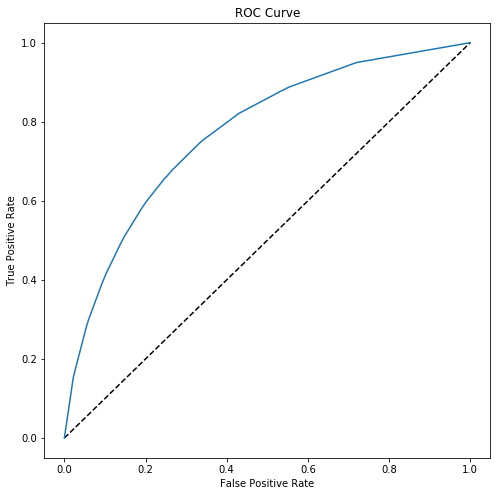

                                 Coefs
log_goal                      0.294288
day                           0.203518
days_to_deadline              0.134998
month                         0.127336
category_name_Tabletop Games  0.023010
category_name_Shorts          0.015052
category_name_Documentary     0.010318
category_name_Food            0.008802
category_slug_design          0.007538
category_name_Theater         0.007509


In [22]:
from sklearn.ensemble import RandomForestClassifier
score_model(rf, X_test, y_test)

feature_list = list(kickstarter_features)
df = pd.DataFrame(rf.feature_importances_, feature_list)
df.columns = ['Coefs']
print(df.sort_values('Coefs', ascending=False).head(10))

In [24]:
# Fitting support vector classifier.  Using a linear model because fit time scales quadratically with normal SVC.

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
fitted = sgd.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
feature_list = list(kickstarter_features)
df = pd.DataFrame(rf.feature_importances_, feature_list)
df.columns = ['Coefs']
print(df.sort_values('Coefs', ascending=False).head(10))


 Accuracy Score: 
 
 70.71%

 Confusion Matrix: 
 
 [[141898  30573]
 [ 53995  62262]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.72      0.82      0.77    172471
           1       0.67      0.54      0.60    116257

    accuracy                           0.71    288728
   macro avg       0.70      0.68      0.68    288728
weighted avg       0.70      0.71      0.70    288728

Probability estimates not available 

                                 Coefs
log_goal                      0.294288
day                           0.203518
days_to_deadline              0.134998
month                         0.127336
category_name_Tabletop Games  0.023010
category_name_Shorts          0.015052
category_name_Documentary     0.010318
category_name_Food            0.008802
category_slug_design          0.007538
category_name_Theater         0.007509


In [25]:
score_model(fitted, X_test, y_test)
feature_list = list(kickstarter_features)
df = pd.DataFrame(rf.feature_importances_, feature_list)
df.columns = ['Coefs']
print(df.sort_values('Coefs', ascending=False).head(10))


 Accuracy Score: 
 
 70.85%

 Confusion Matrix: 
 
 [[69712 15034]
 [26417 31047]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.82      0.77     84746
           1       0.67      0.54      0.60     57464

    accuracy                           0.71    142210
   macro avg       0.70      0.68      0.69    142210
weighted avg       0.70      0.71      0.70    142210

Probability estimates not available 

                                 Coefs
log_goal                      0.294288
day                           0.203518
days_to_deadline              0.134998
month                         0.127336
category_name_Tabletop Games  0.023010
category_name_Shorts          0.015052
category_name_Documentary     0.010318
category_name_Food            0.008802
category_slug_design          0.007538
category_name_Theater         0.007509



 Accuracy Score: 
 
 64.96%

 Confusion Matrix: 
 
 [[156897  15574]
 [ 85588  30669]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.65      0.91      0.76    172471
           1       0.66      0.26      0.38    116257

    accuracy                           0.65    288728
   macro avg       0.66      0.59      0.57    288728
weighted avg       0.65      0.65      0.60    288728



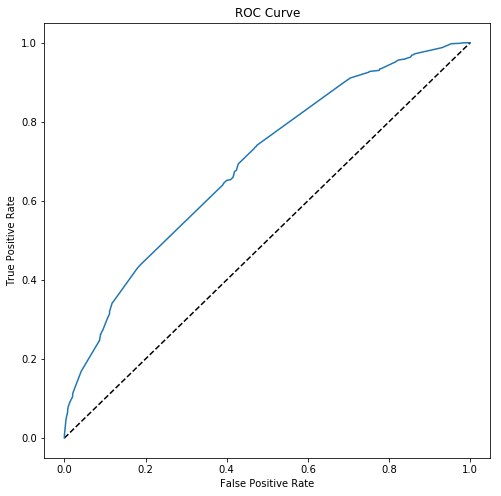

In [27]:
import xgboost as xgb
# find best parameters using grid search
X_train, X_test, y_train, y_test = train_test_split(X, y)
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "objective": ['binary:logistic', 'multi:softmax', 'multi:softprob']}
xgb = xgb.XGBRFClassifier(parameters=params)
fitted = xgb.fit(X_train, y_train)
score_model(fitted, X_train, y_train)


 Accuracy Score: 
 
 64.85%

 Confusion Matrix: 
 
 [[77088  7658]
 [42334 15130]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.65      0.91      0.76     84746
           1       0.66      0.26      0.38     57464

    accuracy                           0.65    142210
   macro avg       0.65      0.59      0.57    142210
weighted avg       0.65      0.65      0.60    142210



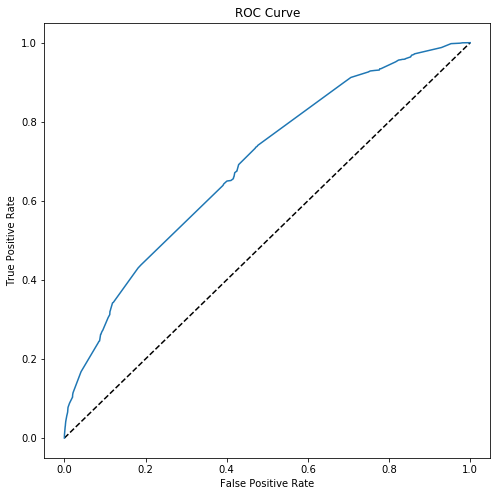

In [28]:
score_model(xgb, X_test, y_test)

In [21]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
        

In [ ]:
score_model(fitted, X_test, y_test)

In [ ]:
# Grid searching features
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

rf.get_params()
parameters = {}
grid = GridSearchCV(estimator=rf, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1)
grid.fit(X_train, y_train)

# Import roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_auc_score

# Extract the best estimator
best_model = grid.best_estimator_

# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

In [ ]:
# Code from the following: 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [30]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Create list of classifiers
classifiers = [('Logistic Regression', logreg), ('Random Forest', rf), ('Multinomial NB', nb), ('XGBoost', xgb), 
               ('SGDClassifier', sgd)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_pred, y_test) 
   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2%}'.format(clf_name, accuracy))

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print('Voting Classifier: {:.2%}'.format(accuracy))

C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression : 72.28%
Random Forest : 71.73%
Multinomial NB : 70.47%
XGBoost : 64.85%
SGDClassifier : 70.85%


C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Voting Classifier: 72.40%
